### Importing Libraries

In [3]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

### Dataset

In [8]:
train=pd.read_csv('C:/Users/admin/Desktop/Internship/4. Walmart/train.csv')

In [9]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [11]:
train['Date']=pd.to_datetime(train['Date'])

In [12]:
train['Month']=train['Date'].dt.month
train['Year']=train['Date'].dt.year
train['Dayofweek']=train['Date'].dt.dayofweek

In [13]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Month,Year,Dayofweek
0,1,1,2010-02-05,24924.50,False,2,2010,4
1,1,1,2010-02-12,46039.49,True,2,2010,4
2,1,1,2010-02-19,41595.55,False,2,2010,4
3,1,1,2010-02-26,19403.54,False,2,2010,4
4,1,1,2010-03-05,21827.90,False,3,2010,4


In [14]:
train.set_index('Date',inplace=True)

In [15]:
sales=train.groupby('Date')['Weekly_Sales'].sum()
sales.head()

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
Name: Weekly_Sales, dtype: float64

Text(0, 0.5, 'Weekly_Sales')

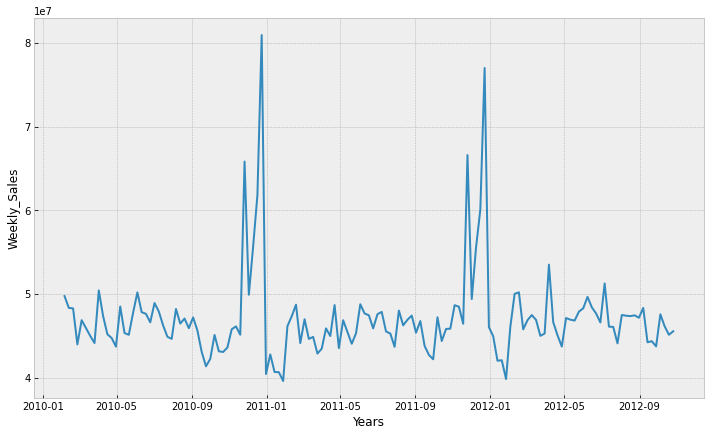

In [16]:
plt.figure(figsize=(12, 7))
plt.plot(sales)
plt.xlabel('Years')
plt.ylabel('Weekly_Sales')

In [17]:
sales_mean=sales.rolling(window=12).mean().round(4)
sales_std=sales.rolling(window=12).std().round(4)
print(sales_mean,sales_std)

Date
2010-02-05             NaN
2010-02-12             NaN
2010-02-19             NaN
2010-02-26             NaN
2010-03-05             NaN
                  ...     
2012-09-28    4.614606e+07
2012-10-05    4.626830e+07
2012-10-12    4.627405e+07
2012-10-19    4.635949e+07
2012-10-26    4.619767e+07
Name: Weekly_Sales, Length: 143, dtype: float64 Date
2010-02-05             NaN
2010-02-12             NaN
2010-02-19             NaN
2010-02-26             NaN
2010-03-05             NaN
                  ...     
2012-09-28    1.630511e+06
2012-10-05    1.680931e+06
2012-10-12    1.680270e+06
2012-10-19    1.582753e+06
2012-10-26    1.556161e+06
Name: Weekly_Sales, Length: 143, dtype: float64


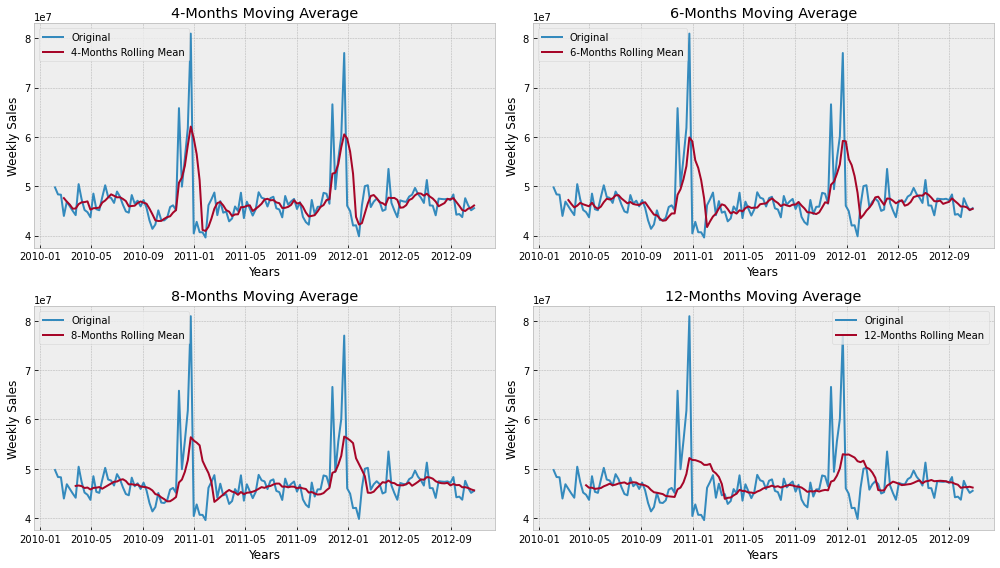

In [18]:
fig, axes = plt.subplots(2, 2)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(sales.index, sales, label='Original')
axes[0][0].plot(sales.index, sales.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Weekly Sales")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(sales.index, sales, label='Original')
axes[0][1].plot(sales.index, sales.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Weekly Sales")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(sales.index, sales, label='Original')
axes[1][0].plot(sales.index, sales.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Weekly Sales")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(sales.index, sales, label='Original')
axes[1][1].plot(sales.index, sales.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Weekly Sales")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

As we could see in the above plots, 12-month moving average could produce a more wrinkle free curve as desired. This on some level is expected since we are using month-wise data for our analysis and there is expected monthly-seasonal effect in our data.

Let's plot the rolling mean and standard deviation on window of 12 months.

##### Step 1.2: Seasonality – Time Series Decomposition
The first thing to do is to see how weekly sales vary on a month basis. We will plot a stacked annual plot to observe seasonality in our data.

In [19]:
train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Month,Year,Dayofweek
Date,,,,,,,
2010-02-05,1,1,24924.50,False,2,2010,4
2010-02-12,1,1,46039.49,True,2,2010,4
2010-02-19,1,1,41595.55,False,2,2010,4
2010-02-26,1,1,19403.54,False,2,2010,4
2010-03-05,1,1,21827.90,False,3,2010,4


In [20]:
monthly_sales = pd.pivot_table(train, values = "Weekly_Sales", columns = "Year", index = "Month")
monthly_sales = monthly_sales.reindex(index = [1,2,3,4,5,6,7,8,9,10,11,12])
monthly_sales

Year,2010,2011,2012
Month,,,
1,NaN,13997.773991,14252.698030
2,16076.778701,15870.141203,16077.647710
3,15432.626612,15182.972005,15589.875454
4,15745.551340,15361.895495,15890.394983
5,15996.481695,15367.864481,15967.389566
6,16486.250953,16188.124643,16309.247563
7,15972.812718,15724.738313,15893.325343
8,16171.689295,16030.542478,16002.348874
9,15120.086691,14961.570247,15239.205709


<AxesSubplot:xlabel='Month'>

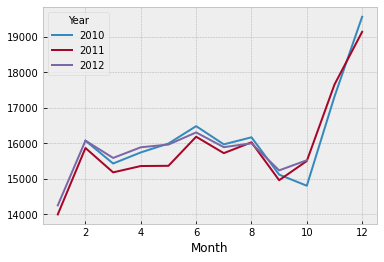

In [21]:
monthly_sales.plot()

#####  Step 1.3: Irregular Remainder – Time Series Decomposition

In [22]:
decomposition = sm.tsa.seasonal_decompose(sales, extrapolate_trend=8)

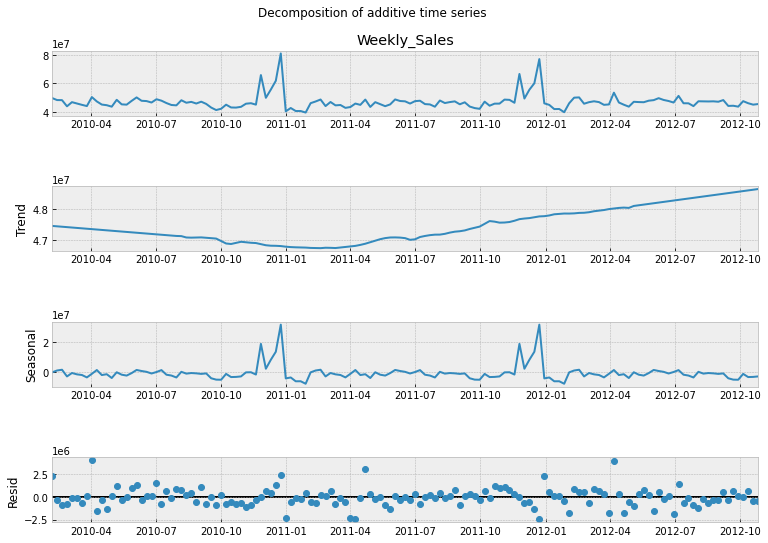

In [23]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of additive time series')
plt.show()

In [24]:
decomp_output = pd.DataFrame(pd.concat([decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid], axis=1))

In [25]:
decomp_output.columns = ['observed', 'Trend', 'Seasonal', 'Irregular']

In [26]:
decomp_output['TSI'] = decomp_output.Trend*decomp_output.Seasonal*decomp_output.Irregular

In [27]:
decomp_output

,observed,Trend,Seasonal,Irregular,TSI
Date,,,,,
2010-02-05,49750740.50,4.746247e+07,2.717348e+02,2.288001e+06,2.950882e+16
2010-02-12,48336677.63,4.744942e+07,1.234856e+06,-3.475975e+05,-2.036685e+19
2010-02-19,48276993.78,4.743637e+07,1.737900e+06,-8.972774e+05,-7.397127e+19
2010-02-26,43968571.13,4.742332e+07,-2.705045e+06,-7.497064e+05,9.617400e+19
2010-03-05,46871470.30,4.741027e+07,-4.231219e+05,-1.156816e+05,2.320610e+18
...,...,...,...,...,...
2012-09-28,43734899.40,4.857360e+07,-4.910067e+06,7.136779e+04,-1.702119e+19
2012-10-05,47566639.31,4.859558e+07,-1.016989e+06,-1.195188e+04,5.906763e+17
2012-10-12,46128514.25,4.861756e+07,-3.124785e+06,6.357362e+05,-9.658067e+19


###  Timeseries Forecasting using FBProphet

In [29]:
#!conda  install -c conda-forge fbprophet --yes
#!pip install fbprophet
from fbprophet import Prophet #you need to install fbprophet using pip install

ModuleNotFoundError: No module named 'fbprophet'

In [27]:
train=train.groupby('Date')[['Weekly_Sales']].sum()

In [28]:
train['ds'] = train.index

In [29]:
train.head()

,Weekly_Sales,ds
Date,,
2010-02-05,49750740.50,2010-02-05
2010-02-12,48336677.63,2010-02-12
2010-02-19,48276993.78,2010-02-19
2010-02-26,43968571.13,2010-02-26
2010-03-05,46871470.30,2010-03-05


In [30]:
train = train[['ds', 'Weekly_Sales']].rename(columns={'ds': 'ds', 'Weekly_Sales': 'y'})

In [31]:
sales_model = Prophet(seasonality_mode='additive',interval_width=0.95)
sales_model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
sales_forecast = sales_model.make_future_dataframe(periods=36, freq='MS')
sales_forecast = sales_model.predict(sales_forecast)

In [85]:
sales_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-05,4.713498e+07,4.164872e+07,5.459406e+07,4.713498e+07,4.713498e+07,7.063785e+05,7.063785e+05,7.063785e+05,7.063785e+05,7.063785e+05,7.063785e+05,0.0,0.0,0.0,4.784136e+07
1,2010-02-12,4.713199e+07,4.189439e+07,5.524951e+07,4.713199e+07,4.713199e+07,1.412247e+06,1.412247e+06,1.412247e+06,1.412247e+06,1.412247e+06,1.412247e+06,0.0,0.0,0.0,4.854424e+07
2,2010-02-19,4.712901e+07,4.036388e+07,5.413556e+07,4.712901e+07,4.712901e+07,3.230487e+04,3.230487e+04,3.230487e+04,3.230487e+04,3.230487e+04,3.230487e+04,0.0,0.0,0.0,4.716131e+07
3,2010-02-26,4.712603e+07,3.936176e+07,5.252291e+07,4.712603e+07,4.712603e+07,-1.180110e+06,-1.180110e+06,-1.180110e+06,-1.180110e+06,-1.180110e+06,-1.180110e+06,0.0,0.0,0.0,4.594592e+07
4,2010-03-05,4.712304e+07,3.914542e+07,5.254591e+07,4.712304e+07,4.712304e+07,-1.452878e+06,-1.452878e+06,-1.452878e+06,-1.452878e+06,-1.452878e+06,-1.452878e+06,0.0,0.0,0.0,4.567016e+07
5,2010-03-12,4.712006e+07,3.897432e+07,5.245420e+07,4.712006e+07,4.712006e+07,-1.508469e+06,-1.508469e+06,-1.508469e+06,-1.508469e+06,-1.508469e+06,-1.508469e+06,0.0,0.0,0.0,4.561159e+07
6,2010-03-19,4.711707e+07,3.898438e+07,5.190747e+07,4.711707e+07,4.711707e+07,-1.857624e+06,-1.857624e+06,-1.857624e+06,-1.857624e+06,-1.857624e+06,-1.857624e+06,0.0,0.0,0.0,4.525945e+07
7,2010-03-26,4.711409e+07,3.844329e+07,5.174089e+07,4.711409e+07,4.711409e+07,-1.976551e+06,-1.976551e+06,-1.976551e+06,-1.976551e+06,-1.976551e+06,-1.976551e+06,0.0,0.0,0.0,4.513754e+07
8,2010-04-02,4.711110e+07,3.927503e+07,5.256775e+07,4.711110e+07,4.711110e+07,-1.292710e+06,-1.292710e+06,-1.292710e+06,-1.292710e+06,-1.292710e+06,-1.292710e+06,0.0,0.0,0.0,4.581839e+07
9,2010-04-09,4.710812e+07,3.993122e+07,5.372627e+07,4.710812e+07,4.710812e+07,-3.271021e+05,-3.271021e+05,-3.271021e+05,-3.271021e+05,-3.271021e+05,-3.271021e+05,0.0,0.0,0.0,4.678102e+07


<Figure size 1296x432 with 0 Axes>

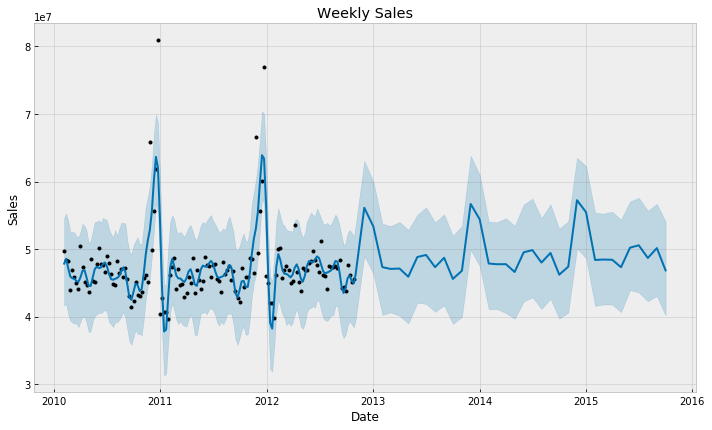

In [34]:
plt.figure(figsize=(18, 6))
sales_model.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Weekly Sales');

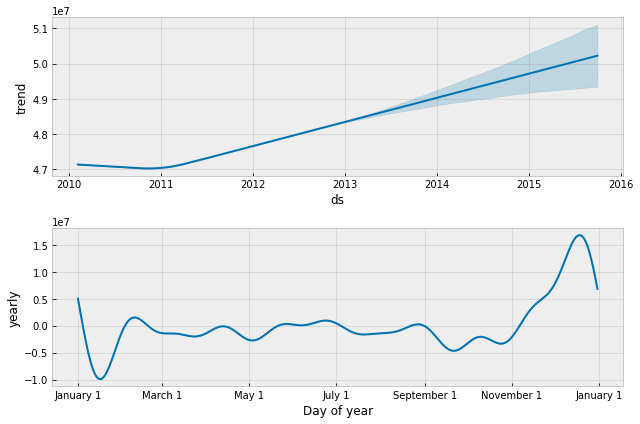

In [35]:
sales_model.plot_components(sales_forecast);

In [36]:
from statsmodels.tsa.stattools import adfuller
adfuller(sales)

(-5.90829795718632,
 2.675979158986205e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 4314.46014989216)

In [37]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -5.908298e+00
p-value                        2.675979e-07
#lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


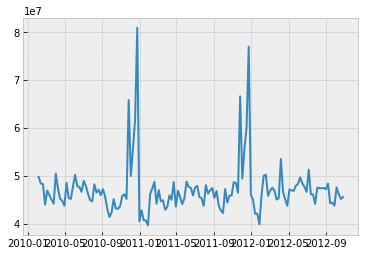

In [38]:
plt.plot(sales)

In [39]:
sales_log = np.log10(sales)

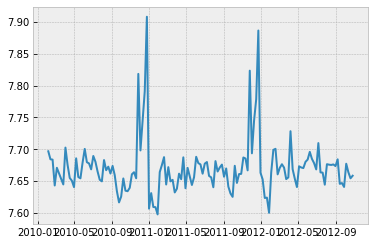

In [40]:
plt.plot(sales_log)

In [41]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_log)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.332826e+00
p-value                        2.878283e-08
#lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


In [42]:
sales.diff(1).head()

Date
2010-02-05           NaN
2010-02-12   -1414062.87
2010-02-19     -59683.85
2010-02-26   -4308422.65
2010-03-05    2902899.17
Name: Weekly_Sales, dtype: float64

In [43]:
sales_diff1 = sales.diff(1)
sales_diff1.dropna(inplace=True)

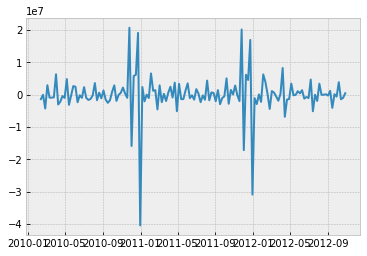

In [44]:
plt.plot(sales_diff1)

In [45]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.699469e+00
p-value                        3.922579e-09
#lags Used                     7.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64


In [46]:
sales_log_diff1 = sales_log.diff(1)
sales_log_diff1.dropna(inplace=True)

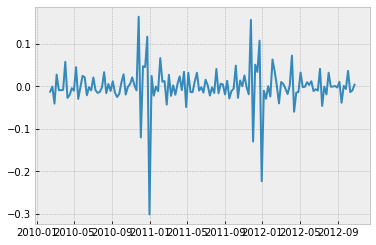

In [47]:
plt.plot(sales_log_diff1)

In [48]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_log_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.747059e+00
p-value                        3.016343e-09
#lags Used                     7.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64


In [49]:
sales_log_diff2 = sales_log.diff(2)
sales_log_diff2.dropna(inplace=True)

In [50]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_log_diff2)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.558182e+00
p-value                        3.059679e-11
#lags Used                     4.000000e+00
Number of Observations Used    1.360000e+02
Critical Value (1%)           -3.479372e+00
Critical Value (5%)           -2.883037e+00
Critical Value (10%)          -2.578234e+00
dtype: float64


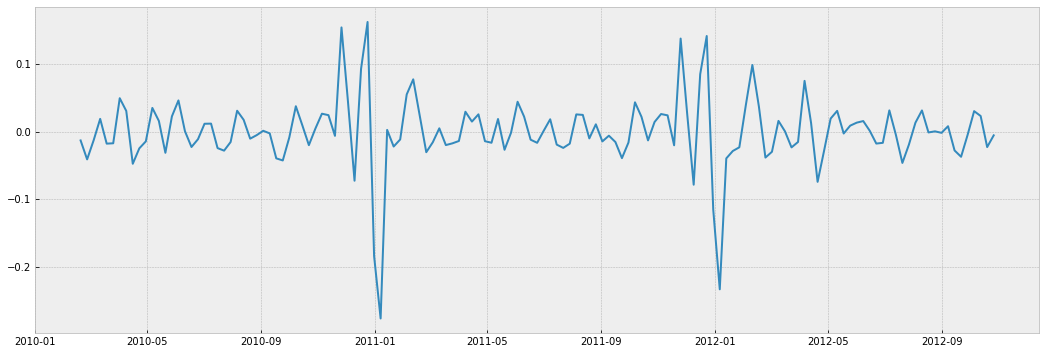

In [51]:
plt.figure(figsize=(18, 6))
plt.plot(sales_log_diff2)

The following are some of our key observations from this analysis: 1) Trend: 12-months moving average looks quite similar to a straight line hence we could have easily used linear regression to estimate the trend in this data. 2) Seasonality: As discussed, seasonal plot displays a fairly consistent month-on-month pattern. The monthly seasonal components are average values for a month after removal of trend. Trend is removed from the time series using the following formula:

      Seasonalityt×Remaindert=YtTrendt

3) Irregular Remainder (random): is the residual left in the series after removal of trend and seasonal components. Remainder is calculated using the following formula:

       Remaindert=YtTrendt×Seasonalityt
The expectations from remainder component is that it should look like a white noise i.e. displays no pattern at all. However, for our series residual display some pattern with high variation on the edges of data i.e. near the beginning (2011-2012) and the end (2011-2012) of the series.

### ARIMA Modeling

Step 2: Difference data to make data stationary on mean (remove trend)

Clearly the tractor sales has an upward trend for weekly sales and there is also a seasonal component that we have already analyzed.

The next thing to do is to make the series stationary by removing the upward trend through 1st order differencing of the series using the following formula:

1st Differencing (d=1) | Y′t=Yt−Yt−1

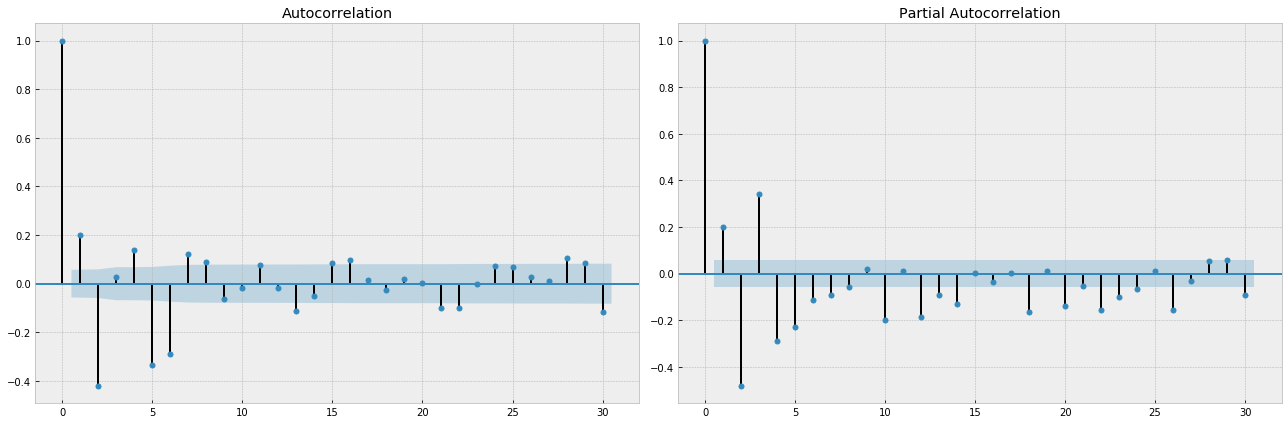

In [52]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(18)
fig.set_figheight(6)
smt.graphics.plot_acf(sales_log_diff2, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_log_diff2, lags=30, ax=axes[1], alpha=0.5,method='ols')
plt.tight_layout()

#### Step 6: Identification of best fit ARIMA model

In [53]:
model = sm.tsa.statespace.SARIMAX(sales_log_diff2, order = (1,0,1), seasonal_order= (1,0,0,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)

C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [54]:
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       Weekly_Sales   No. Observations:                  141
Model:             SARIMAX(1, 0, 1)x(1, 0, 0, 12)   Log Likelihood                 212.406
Date:                            Thu, 30 Jan 2020   AIC                           -416.812
Time:                                    21:06:00   BIC                           -405.404
Sample:                                02-19-2010   HQIC                          -412.177
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3654      0.063     -5.825      0.000      -0.488      -0.242
ma.L1          1.0000    141.433   

### Iterate the process to find the best values for p, d, q and P, D, Q

In [55]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 2)
d = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

In [56]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [57]:
# Generate all different combinations of seasonal p, q and q triplets
D = range(0,2)
P = Q = range(0, 2) 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [58]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(0, 0, 0, 12)12 model - AIC:-492.971404315493


#### Step 7: Predict sales on in-sample date using the best fit ARIMA model

The next step is to predict weekly sales for in-sample data and find out how close is the model prediction on the in-sample data to the actual truth.

In [59]:
best_model = sm.tsa.statespace.SARIMAX(sales_log,
                                      order=(1, 1, 1),
                                      seasonal_order=(0, 0, 0, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [60]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                           Statespace Model Results                           
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 249.486
Date:                Thu, 30 Jan 2020   AIC                           -492.971
Time:                        21:06:21   BIC                           -484.146
Sample:                    02-05-2010   HQIC                          -489.385
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3754      0.048      7.743      0.000       0.280       0.470
ma.L1         -1.0000     56.849     -0.018      0.986    -112.423     110.423
sigma2         0.0016      0.091      0.018      0.9

In [61]:
sales

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
2010-03-12    45925396.51
2010-03-19    44988974.64
2010-03-26    44133961.05
2010-04-02    50423831.26
2010-04-09    47365290.44
2010-04-16    45183667.08
2010-04-23    44734452.56
2010-04-30    43705126.71
2010-05-07    48503243.52
2010-05-14    45330080.20
2010-05-21    45120108.06
2010-05-28    47757502.56
2010-06-04    50188543.12
2010-06-11    47826546.72
2010-06-18    47622046.23
2010-06-25    46609036.29
2010-07-02    48917484.50
2010-07-09    47899529.37
2010-07-16    46243899.58
2010-07-23    44888849.11
2010-07-30    44630363.42
2010-08-06    48204999.12
2010-08-13    46464418.41
2010-08-20    47060952.92
2010-08-27    45909740.44
                 ...     
2012-04-06    53502315.87
2012-04-13    46629261.41
2012-04-20    45072529.78
2012-04-27    43716798.89
2012-05-04    47124197.93
2012-05-11    46925878.99
2012-05-18    46823939.22
2012-05

In [62]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-09-14'), full_results=True)

In [63]:
pred_dynamic.predicted_mean

2012-09-14    7.676189
2012-09-21    7.661498
2012-09-28    7.661864
2012-10-05    7.659418
2012-10-12    7.673239
2012-10-19    7.668168
2012-10-26    7.664475
Freq: W-FRI, dtype: float64

In [64]:
forecast=np.power(10, pred_dynamic.predicted_mean)

In [65]:
actual = sales['2012-09-14':]
actual

Date
2012-09-14    44226038.65
2012-09-21    44354547.11
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, dtype: float64

In [66]:
#Mean absolute percentage error
MAPE_last1year = np.mean(np.abs(actual - forecast)/actual)

In [67]:
print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE_last1year, 4)))

The Mean Absolute percentage error of our forecast for last two years is 0.0378


In [68]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

The Mean Squared Error of our forecasts is 3507665915974.3096
The ROOT Mean Squared Error of our forecasts is 1872876.374984294


In [69]:
np.power(10, best_results.forecast(steps=12))

2012-11-02    4.633924e+07
2012-11-09    4.664130e+07
2012-11-16    4.675519e+07
2012-11-23    4.679802e+07
2012-11-30    4.681411e+07
2012-12-07    4.682015e+07
2012-12-14    4.682242e+07
2012-12-21    4.682327e+07
2012-12-28    4.682359e+07
2013-01-04    4.682371e+07
2013-01-11    4.682375e+07
2013-01-18    4.682377e+07
Freq: W-FRI, dtype: float64

#### Step 8: Forecast sales using the best fit ARIMA model

The next step is to predict weekly sales for next 3 years i.e. for 2013, 2014, and 2015 through the above model.

In [70]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [71]:
pred_ci_99.head()

,lower Weekly_Sales,upper Weekly_Sales
2012-11-02,7.587072,7.744826
2012-11-09,7.584325,7.753216
2012-11-16,7.584557,7.755102
2012-11-23,7.584812,7.755643
2012-11-30,7.584931,7.755822


In [72]:
pred_ci_95.head()

,lower Weekly_Sales,upper Weekly_Sales
2012-11-02,7.587072,7.744826
2012-11-09,7.584325,7.753216
2012-11-16,7.584557,7.755102
2012-11-23,7.584812,7.755643
2012-11-30,7.584931,7.755822


In [73]:
n_steps = 36
idx = pd.date_range(sales.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

In [74]:
fc_95.head()

,forecast,lower_ci_95,upper_ci_95
2012-11-01,4.633924e+07,3.864310e+07,5.556814e+07
2012-12-01,4.664130e+07,3.839949e+07,5.665206e+07
2013-01-01,4.675519e+07,3.842000e+07,5.689870e+07
2013-02-01,4.679802e+07,3.844254e+07,5.696956e+07
2013-03-01,4.681411e+07,3.845308e+07,5.699311e+07


In [75]:
fc_99.head()

,lower_ci_99,upper_ci_99
2012-11-01,3.864310e+07,5.556814e+07
2012-12-01,3.839949e+07,5.665206e+07
2013-01-01,3.842000e+07,5.689870e+07
2013-02-01,3.844254e+07,5.696956e+07
2013-03-01,3.845308e+07,5.699311e+07


In [77]:
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2012-11-01,4.633924e+07,3.864310e+07,5.556814e+07,3.864310e+07,5.556814e+07
2012-12-01,4.664130e+07,3.839949e+07,5.665206e+07,3.839949e+07,5.665206e+07
2013-01-01,4.675519e+07,3.842000e+07,5.689870e+07,3.842000e+07,5.689870e+07
2013-02-01,4.679802e+07,3.844254e+07,5.696956e+07,3.844254e+07,5.696956e+07
2013-03-01,4.681411e+07,3.845308e+07,5.699311e+07,3.845308e+07,5.699311e+07


In [78]:
pd.plotting.register_matplotlib_converters()

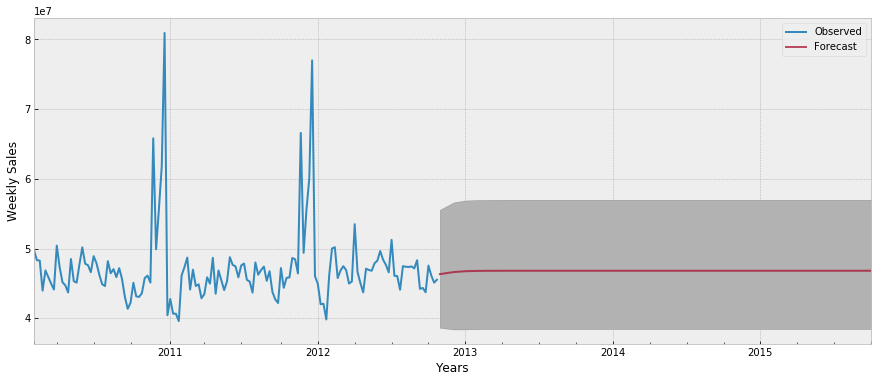

In [87]:
# plot the forecast along with the confidence band
axis = sales.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Weekly Sales')
plt.legend(loc='best')
plt.show()

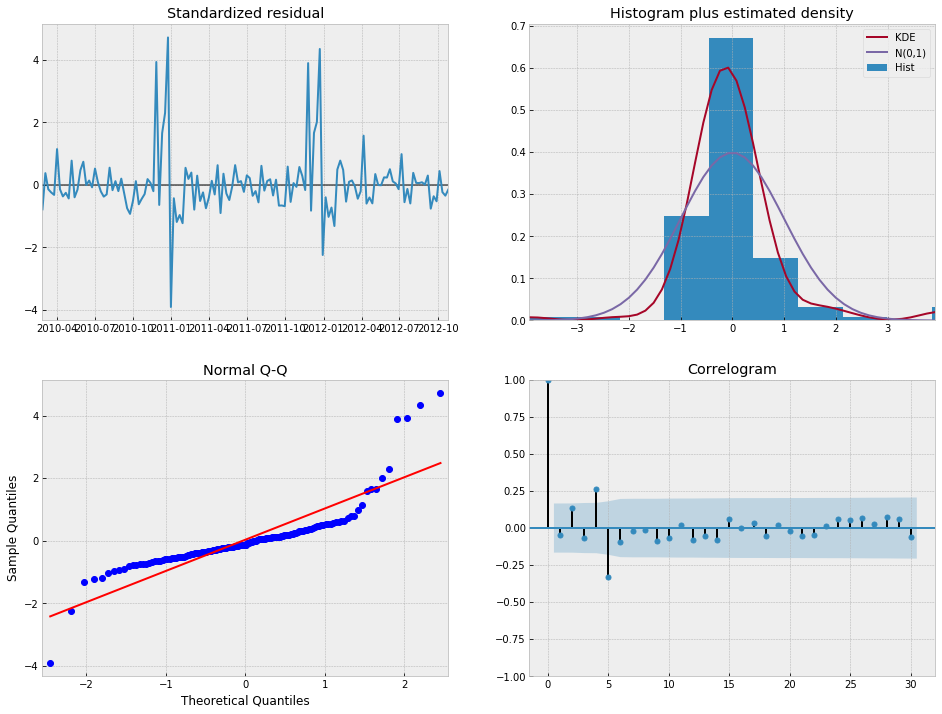

In [80]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

## Single Exponential Smoothing

In [81]:
### single exponential smoothing/ ETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# our guessed parameters
alpha = 0.4
beta = 0.2
gamma = 0.01

# initialise model
ets_model = ExponentialSmoothing(sales, trend='add', seasonal='add', seasonal_periods=12)
#ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
ets_fit = ets_model.fit(optimized=True)

In [82]:
# forecast p months ahead
p_ahead = 36
yh = ets_fit.forecast(p_ahead)

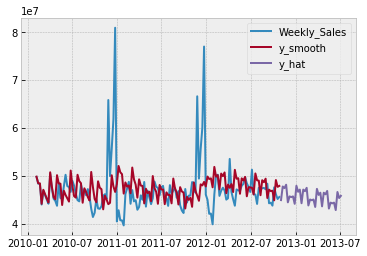

In [83]:
# plot the y, y_smoothed and y_hat ts'
plt.plot(sales, label='Weekly_Sales')
plt.plot(ets_fit.fittedvalues, label='y_smooth')
plt.plot(yh, label='y_hat')

plt.legend()
plt.show()